In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
file_location = "/kaggle/input/main-dataset-g-bert/Datasets/40K-Dataset-Main.xlsx"

df_org = pd.read_excel(file_location, sheet_name="Sheet1")
df_org = df_org.sample(frac=1.0, random_state=50) # Shuffle the data
print(df_org.head())

                                                    Text     Emotion
15696     আমি খুব স্থির বোধ করছি কিন্তু একরকম খুব বিষণ্ণ  Optimistic
20287                          আমি আরও শক্তিশালী বোধ করি  Optimistic
16986  আমি এমনভাবে অনুভব করি যে আমি আমার ক্যালোরি গ্র...  Astonished
37937  পিঁয়াজের মূল্য ২০০২৫০ টাকা কেজি এই হঠাৎ মূল্যব...     Sadness
24561  মাঝে মাঝে মনে হয় তোমার সাথে আমার হৃদয়টা পাল্...     Sadness


In [4]:
# df_org["text_clean"] = df_org["TEXT"]
# df_org["Emotion"] = df_org["classes"]
df_org["text_clean"] = df_org["Text"]

# Drop duplicates
df_org.drop_duplicates(subset=['text_clean'], inplace=True)

# Drop rows with empty text_clean
df_org.dropna(subset=['text_clean'], inplace=True)

data_count = df_org.shape[0]
print("Remaining data count after deleting duplicates and empty rows:", data_count)

Remaining data count after deleting duplicates and empty rows: 40507


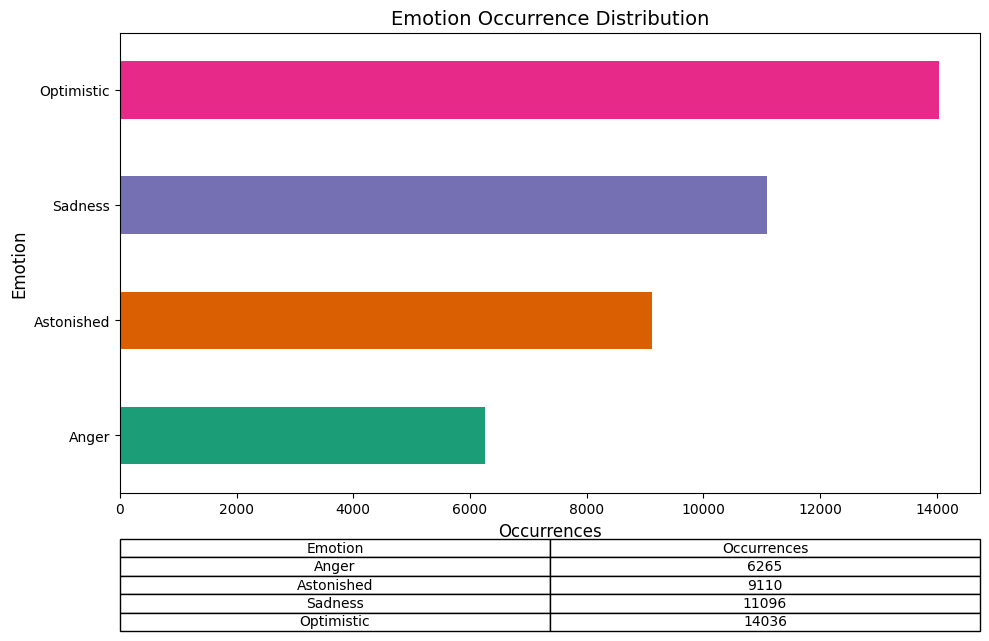

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'Emotion' and count occurrences, sorted for better visual
emotion_counts = df_org.groupby('Emotion').size().sort_values(ascending=True)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
emotion_counts.plot(
    kind='barh', 
    color=sns.color_palette('Dark2', len(emotion_counts))
)

# Add titles and labels
plt.title('Emotion Occurrence Distribution', fontsize=14)
plt.xlabel('Occurrences', fontsize=12)
plt.ylabel('Emotion', fontsize=12)

# Display the table below the chart
plt.table(
    cellText=emotion_counts.reset_index().values,
    colLabels=['Emotion', 'Occurrences'],
    cellLoc='center',
    loc='bottom',
    bbox=[0, -0.3, 1, 0.2]
)

# Adjust layout and save
plt.subplots_adjust(left=0.2, bottom=0.4)
plt.tight_layout()
plt.show()

In [6]:
# Tokenize the text and calculate word counts
df_org['word_list'] = df_org['text_clean'].str.split()  # Split text into words
total_words = df_org['word_list'].explode().count()     # Total number of words
unique_words = df_org['word_list'].explode().nunique()  # Number of unique words

# Display results
print(f"Total words: {total_words}")
print(f"Unique words: {unique_words}")

Total words: 730022
Unique words: 43360


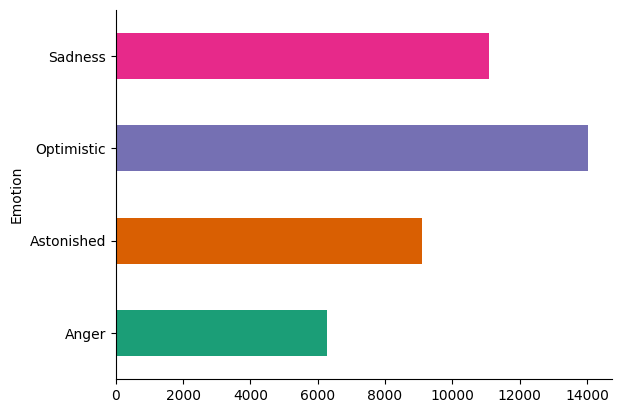

In [7]:
df_org.groupby('Emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

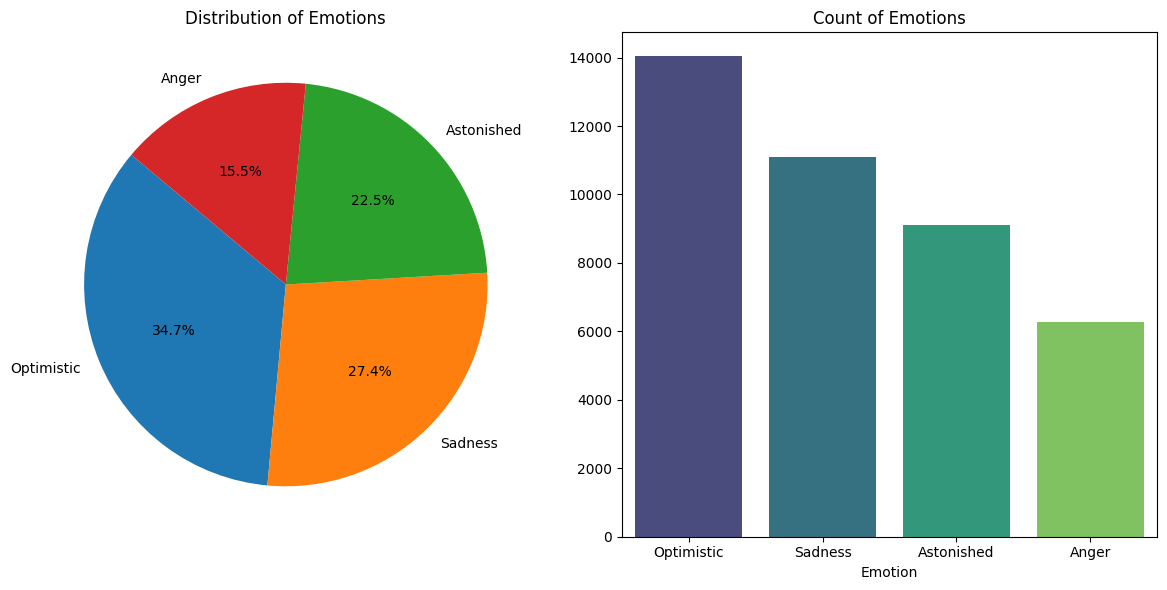

In [8]:
# Value Count Of Label
count = df_org['Emotion'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Emotions')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Emotions')

plt.tight_layout()
plt.show()

### Cleanning and Preprocessing Bangla Data

In [9]:
# def preprocess_with_negation(text):
#     negation_words = ["না", "নেই"]  # List of negation words
#     for negation in negation_words:
#         if negation in text:
#             text = text.replace(negation, f"{negation}_NEG")  # Tag negations explicitly
#     return text

# df_org["text_clean"] = df_org["text_clean"].apply(preprocess_with_negation)

In [10]:
# !pip install bangla-stemmer

In [11]:
# from bangla_stemmer.stemmer import stemmer

# stmr = stemmer.BanglaStemmer()

# valid_bangla_char = set(['া','ি','ী','ু','ূ','ৃ','ে','ৈ','ো','ৌ','ক','খ',
# 'গ','ঘ','ঙ','চ','ছ','জ','ঝ','ঞ','ট','ঠ','ড','ঢ','ণ','ত','থ','দ','ধ','ন',
# 'প','ফ','ব','ভ','ম','য','র','ল','শ','ষ','স','হ','ড়','ঢ়','য়','ৎ','ং','ঃ'
# '‍ঁ','‍্','‍্য','‍‍্র','‍‍র্ক','‍্ব','৺','ক্ষ','জ্ঞ','অ','আ','ই','ঈ','উ','ঊ','ঋ','এ',
# 'ঐ','ও','ঔ','অ্যা','্','য়','ঁ','ড়','়','ঃ'])

# stop_words = set([''])
# stop_words_file_lines=open('/kaggle/input/g-bert-dataset-01/stop_words.txt','r',encoding='utf-8-sig').readlines()
# for word in stop_words_file_lines:
#     stop_words.add(word.strip())

# def puncuation_removal(sentence):
#     words = sentence.split()
#     unique_words_per_sentence = []
#     for every_word in words:
#         correct_word = ''
#         for each_char in every_word:
#             if each_char in valid_bangla_char:
#                 correct_word += each_char
#             else:
#                 correct_word = ''
#         if correct_word not in stop_words:
#             unique_words_per_sentence.append(correct_word.strip())
#         correct_word = ''

#     new_refined_sentence = ' '.join(stmr.stem(unique_words_per_sentence))

#     return new_refined_sentence

# df_org["Text"] = df_org["text_clean"].apply(lambda x: puncuation_removal(x))
# df_org["text_clean"] = df_org["Text"]
# df_org.head()

In [12]:
# # Optionally, save the updated dataframe to a new CSV file or overwrite the original one
# df_org.to_csv('updated_dataset.csv', index=False)

In [13]:
# Import Basis Needed Libaries 
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

# # Download NLTK resources (uncomment the following line if not already downloaded)?
# nltk.download('punkt')
# nltk.download('stopwords')

In [14]:
# # Step 2: Remove special characters and punctuation
# df_org["text_clean"] = df_org["text_clean"].str.replace(r'[^\w\s]', '', regex=True)

# # Step 3: Remove extra whitespaces
# df_org["text_clean"] = df_org["text_clean"].str.replace(r'\s+', ' ', regex=True)

# # Step : 4 Remove numeric values
# df_org["text_clean"] = df_org["text_clean"].str.replace(r'\d+', '', regex=True)

# # Step 8: Remove stop words
# stop = stopwords.words('bengali')
# df_org["text_clean"] = df_org["text_clean"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# # Display the first few rows of the DataFrame to verify the changes
# df_org.head()


In [15]:
labels = df_org['Emotion'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Optimistic', 'Astonished', 'Sadness', 'Anger']

In [16]:
NUM_LABELS= len(labels)
id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

print(label2id)
print(id2label)

{'Optimistic': 0, 'Astonished': 1, 'Sadness': 2, 'Anger': 3}
{0: 'Optimistic', 1: 'Astonished', 2: 'Sadness', 3: 'Anger'}


In [17]:
df_org["labels"]=df_org.Emotion.map(lambda x: label2id[x.strip()])
df_org.head(10)

,Text,Emotion,text_clean,word_list,labels
15696,আমি খুব স্থির বোধ করছি কিন্তু একরকম খুব বিষণ্ণ,Optimistic,আমি খুব স্থির বোধ করছি কিন্তু একরকম খুব বিষণ্ণ,"[আমি, খুব, স্থির, বোধ, করছি, কিন্তু, একরকম, খু...",0
20287,আমি আরও শক্তিশালী বোধ করি,Optimistic,আমি আরও শক্তিশালী বোধ করি,"[আমি, আরও, শক্তিশালী, বোধ, করি]",0
16986,আমি এমনভাবে অনুভব করি যে আমি আমার ক্যালোরি গ্র...,Astonished,আমি এমনভাবে অনুভব করি যে আমি আমার ক্যালোরি গ্র...,"[আমি, এমনভাবে, অনুভব, করি, যে, আমি, আমার, ক্যা...",1
37937,পিঁয়াজের মূল্য ২০০২৫০ টাকা কেজি এই হঠাৎ মূল্যব...,Sadness,পিঁয়াজের মূল্য ২০০২৫০ টাকা কেজি এই হঠাৎ মূল্যব...,"[পিঁয়াজের, মূল্য, ২০০২৫০, টাকা, কেজি, এই, হঠাৎ...",2
24561,মাঝে মাঝে মনে হয় তোমার সাথে আমার হৃদয়টা পাল্...,Sadness,মাঝে মাঝে মনে হয় তোমার সাথে আমার হৃদয়টা পাল্...,"[মাঝে, মাঝে, মনে, হয়, তোমার, সাথে, আমার, হৃদয...",2
17479,আমি মনে করি জার্সিটি একটু বেশি দুঃসাহসিক হতে প...,Optimistic,আমি মনে করি জার্সিটি একটু বেশি দুঃসাহসিক হতে প...,"[আমি, মনে, করি, জার্সিটি, একটু, বেশি, দুঃসাহসি...",0
31422,আধুনিকতা আর দৃষ্টিনন্দন নকশার কারণে দেশের বাজা...,Astonished,আধুনিকতা আর দৃষ্টিনন্দন নকশার কারণে দেশের বাজা...,"[আধুনিকতা, আর, দৃষ্টিনন্দন, নকশার, কারণে, দেশে...",1
32338,আমি আজ খুব হতাশ বোধ করছি,Sadness,আমি আজ খুব হতাশ বোধ করছি,"[আমি, আজ, খুব, হতাশ, বোধ, করছি]",2
9521,মোবাইল বের করে সময় দেখে আবারও চমকে উঠে সে ভোর ...,Astonished,মোবাইল বের করে সময় দেখে আবারও চমকে উঠে সে ভোর ...,"[মোবাইল, বের, করে, সময়, দেখে, আবারও, চমকে, উঠে...",1
31720,আমি জানি না তবে আমি কেন এমন লোকদের সামনে অস্বস...,Astonished,আমি জানি না তবে আমি কেন এমন লোকদের সামনে অস্বস...,"[আমি, জানি, না, তবে, আমি, কেন, এমন, লোকদের, সা...",1


<Axes: ylabel='count'>

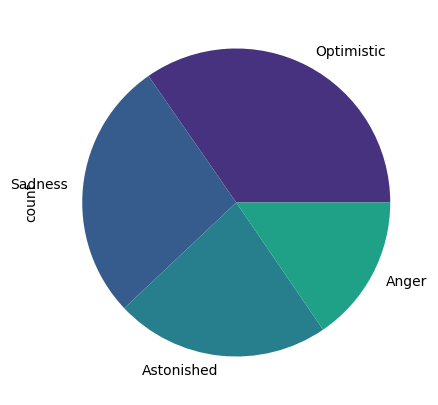

In [18]:
df_org.Emotion	.value_counts().plot(kind='pie', figsize=(5,5))

In [19]:
model_name = "sagorsarker/bangla-bert-base"
# model_name = "csebuetnlp/banglabert"

tokenizer = BertTokenizerFast.from_pretrained(model_name, max_length=512)

model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=NUM_LABELS, 
    id2label=id2label, 
    label2id=label2id
)

model.to(device)

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [20]:
SIZE = df_org.shape[0]

train_texts = list(df_org.text_clean[:int(0.70 * SIZE)])
val_texts = list(df_org.text_clean[int(0.70 * SIZE):int(0.85 * SIZE)])
test_texts = list(df_org.text_clean[int(0.85 * SIZE):])

train_labels = list(df_org.labels[:int(0.70 * SIZE)])
val_labels = list(df_org.labels[int(0.70 * SIZE):int(0.85 * SIZE)])
test_labels = list(df_org.labels[int(0.85 * SIZE):])

print(f"Train size: {len(train_texts)}")
print(f"Val size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

Train size: 28354
Val size: 6076
Test size: 6077


In [21]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [22]:
class BanglaEmotionDataset(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

train_dataloader = BanglaEmotionDataset(train_encodings, train_labels)
val_dataloader = BanglaEmotionDataset(val_encodings, val_labels)
test_dataset = BanglaEmotionDataset(test_encodings, test_labels)

print(train_labels[:5])  # Check the first 5 labels

[0, 0, 1, 2, 2]


In [23]:
from transformers import TrainingArguments, Trainer

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, macro F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object with label_ids and predictions attributes.
            - label_ids (array-like): True class labels.
            - predictions (array-like): Logits or probabilities per class.
              
    Returns:
        dict: Contains 'accuracy', 'f1', 'precision', and 'recall'.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [25]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/TTC4900Model',
    do_train=True,
    do_eval=True,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./kaggle/working/multi-class-logs',
    logging_steps=250,
    eval_strategy="epoch", 
    save_strategy="epoch",
    save_total_limit=1,
    fp16=True,
    load_best_model_at_end=True,
    seed=42
)

In [26]:
trainer = Trainer(
    model=model,                     
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
# Key = 1bac103b24344b2363b31af4b945c0fd4c7a1381 // Wanb AI Key

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.683400,0.607760,0.781600,0.765546,0.769016,0.768452
2,0.459900,0.547026,0.804312,0.789579,0.797565,0.785395
3,0.305200,0.578916,0.816327,0.804581,0.802995,0.811042
4,0.190900,0.646216,0.821429,0.807864,0.806255,0.810154
5,0.119700,0.897756,0.816327,0.801030,0.804837,0.799098
6,0.069300,1.194853,0.823733,0.809294,0.808740,0.809983


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


TrainOutput(global_step=5322, training_loss=0.3285776680011312, metrics={'train_runtime': 5877.9568, 'train_samples_per_second': 28.943, 'train_steps_per_second': 0.905, 'total_flos': 2.7277032030453504e+16, 'train_loss': 0.3285776680011312, 'epoch': 6.0})

In [27]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
train,0.286175,0.904458,0.897288,0.902951,0.892938
val,0.547026,0.804312,0.789579,0.797565,0.785395
test,0.549186,0.799243,0.782596,0.796178,0.774036


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Evaluation Metrics (Loss, Accuracy, etc.):
             eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall
Train        0.286175       0.904458  0.897288        0.902951     0.892938
Validation   0.547026       0.804312  0.789579        0.797565     0.785395
Test         0.549186       0.799243  0.782596        0.796178     0.774036


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



📊 Train Classification Report:
              precision    recall  f1-score   support

  Optimistic       0.90      0.97      0.93      9814
  Astonished       0.92      0.89      0.91      6348
     Sadness       0.92      0.87      0.89      7796
       Anger       0.87      0.84      0.86      4396

    accuracy                           0.90     28354
   macro avg       0.90      0.89      0.90     28354
weighted avg       0.90      0.90      0.90     28354


📊 Validation Classification Report:
              precision    recall  f1-score   support

  Optimistic       0.80      0.91      0.85      2061
  Astonished       0.85      0.76      0.80      1427
     Sadness       0.83      0.76      0.79      1675
       Anger       0.71      0.71      0.71       913

    accuracy                           0.80      6076
   macro avg       0.80      0.79      0.79      6076
weighted avg       0.81      0.80      0.80      6076


📊 Test Classification Report:
              precision    rec

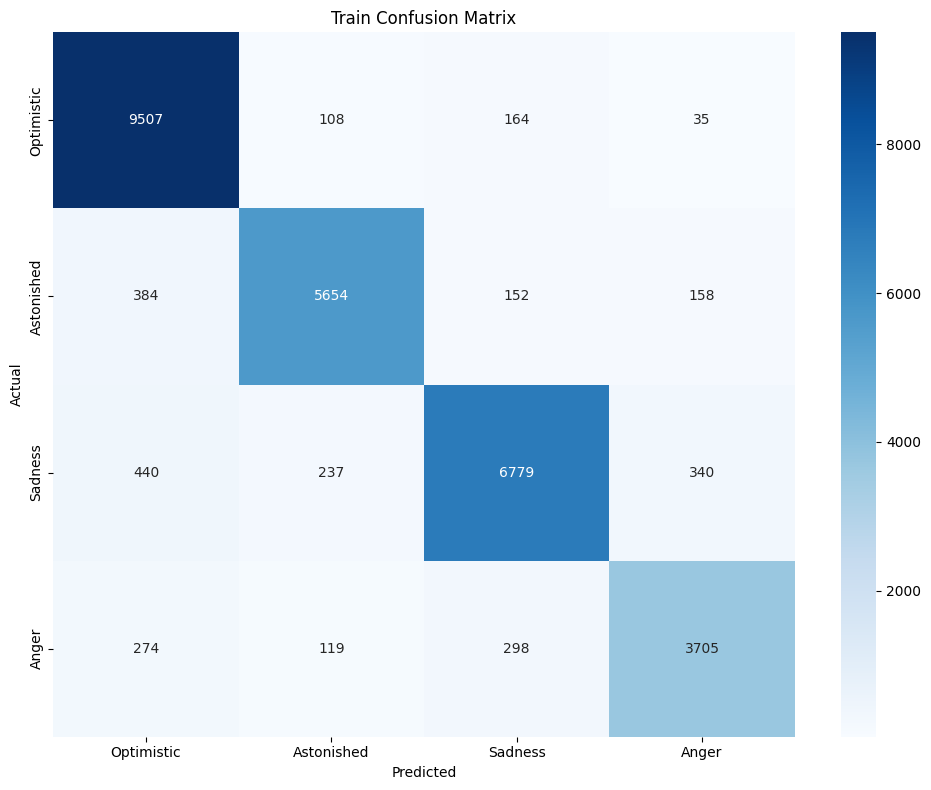

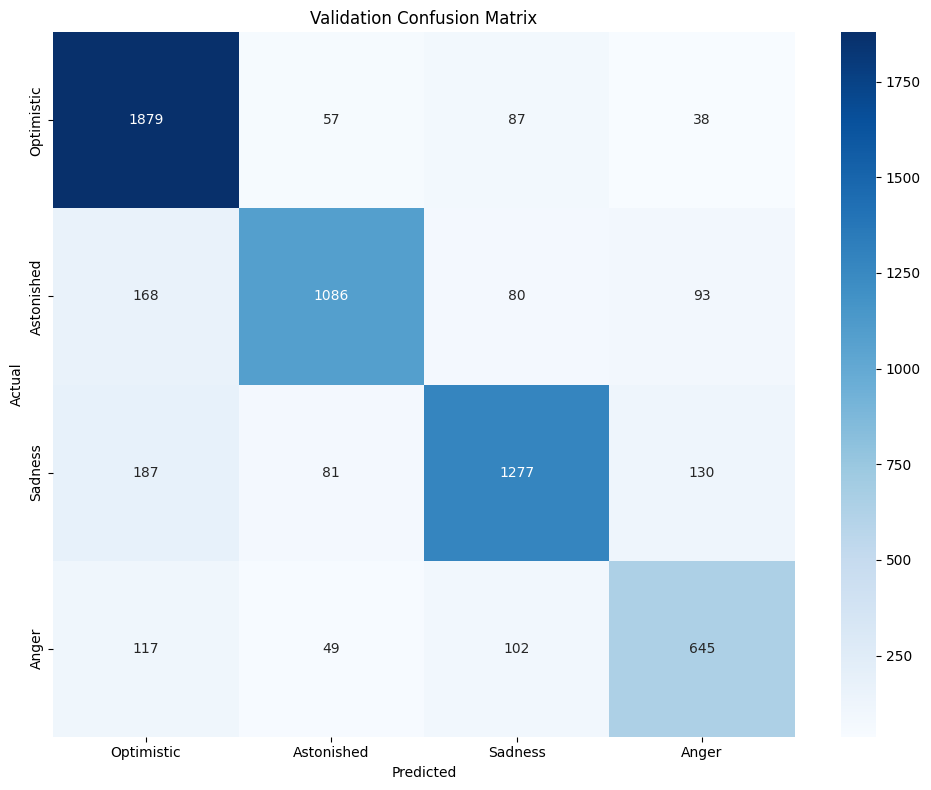

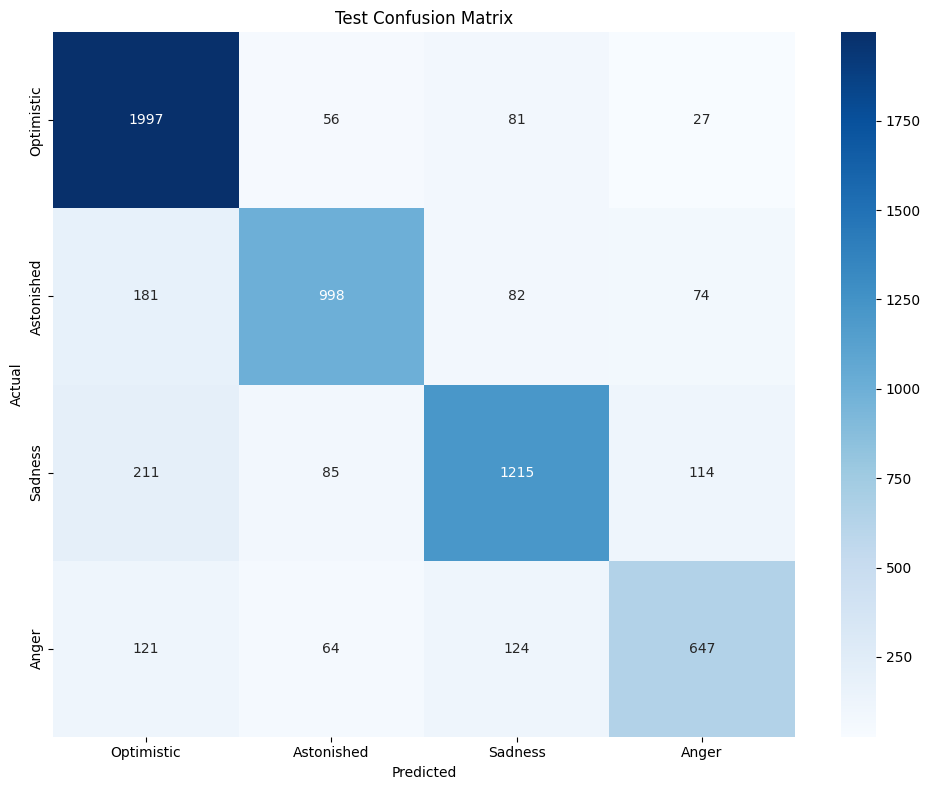


🔎 Average Metrics for Train Set:
Precision: 0.9025
Recall:    0.8925
F1 Score:  0.8975

🔎 Average Metrics for Validation Set:
Precision: 0.7975
Recall:    0.7850
F1 Score:  0.7875

🔎 Average Metrics for Test Set:
Precision: 0.7975
Recall:    0.7750
F1 Score:  0.7850


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Step 1: Evaluate on all sets ----------
evaluation_results = [
    trainer.evaluate(eval_dataset=ds) 
    for ds in [train_dataloader, val_dataloader, test_dataset]
]

df_metrics = pd.DataFrame(evaluation_results, index=["Train", "Validation", "Test"]).iloc[:, :5]
print("Evaluation Metrics (Loss, Accuracy, etc.):\n", df_metrics)

# ---------- Step 2: Predict on datasets ----------
def get_predictions_and_labels(dataloader, true_labels):
    preds = trainer.predict(dataloader)
    pred_labels = preds.predictions.argmax(axis=1)
    return pred_labels, true_labels

train_pred_labels, train_true_labels = get_predictions_and_labels(train_dataloader, train_labels)
val_pred_labels, val_true_labels = get_predictions_and_labels(val_dataloader, val_labels)
test_pred_labels, test_true_labels = get_predictions_and_labels(test_dataset, test_labels)

# ---------- Step 3: Define class labels ----------
labels = list(range(NUM_LABELS))
target_names = [id2label[i] for i in labels]

# ---------- Step 4: Report generator ----------
def generate_report(true_labels, pred_labels, dataset_name):
    print(f"\n📊 {dataset_name} Classification Report:")
    report = classification_report(true_labels, pred_labels, labels=labels, target_names=target_names)
    print(report)
    return report

# Generate reports
train_report = generate_report(train_true_labels, train_pred_labels, "Train")
val_report = generate_report(val_true_labels, val_pred_labels, "Validation")
test_report = generate_report(test_true_labels, test_pred_labels, "Test")

# ---------- Step 5: Confusion Matrix Plot ----------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot all confusion matrices
plot_confusion_matrix(train_true_labels, train_pred_labels, "Train Confusion Matrix")
plot_confusion_matrix(val_true_labels, val_pred_labels, "Validation Confusion Matrix")
plot_confusion_matrix(test_true_labels, test_pred_labels, "Test Confusion Matrix")

# ---------- Step 6: Aggregate Metrics ----------
def extract_avg_scores(report_text):
    report_lines = report_text.strip().split('\n')
    metrics = {
        line.split()[0]: {
            'precision': float(line.split()[1]),
            'recall': float(line.split()[2]),
            'f1-score': float(line.split()[3])
        }
        for line in report_lines[2:] if line.strip() and line.split()[0] in target_names
    }

    # Calculate average
    avg = {
        metric: sum(class_scores[metric] for class_scores in metrics.values()) / len(metrics)
        for metric in ['precision', 'recall', 'f1-score']
    }

    return avg

# Compute average scores
train_avg = extract_avg_scores(train_report)
val_avg = extract_avg_scores(val_report)
test_avg = extract_avg_scores(test_report)

# ---------- Step 7: Display Average Metrics ----------
def print_avg_metrics(avg_metrics, name):
    print(f"\n🔎 Average Metrics for {name} Set:")
    print(f"Precision: {avg_metrics['precision']:.4f}")
    print(f"Recall:    {avg_metrics['recall']:.4f}")
    print(f"F1 Score:  {avg_metrics['f1-score']:.4f}")

print_avg_metrics(train_avg, "Train")
print_avg_metrics(val_avg, "Validation")
print_avg_metrics(test_avg, "Test")

In [31]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

'''def preprocess_with_negation_v2(text):
    """
    Modify text to highlight the presence of negation words.
    """
    negation_words = ["না", "নেই"]
    for negation in negation_words:
        if negation in text:
            text = f"{text} (Negative context: {negation})"
    return text


def predict_with_negation_v2(text):
    """
    Predicts the class label for a given input text with negation handling.

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Ensure the model is on the correct device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Step 1: Preprocess the text to handle negations
    text = preprocess_with_negation_v2(text)

    # Step 2: Tokenize the input text and move tensors to the same device as the model
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    # Step 3: Get model output (logits)
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(**inputs)

    probs = outputs.logits.softmax(1)

    # Step 4: Get the index of the class with the highest probability
    pred_label_idx = probs.argmax()

    # Map the predicted class index to the actual class label
    pred_label = model.config.id2label[pred_label_idx.item()]

    # Step 5: Adjust prediction if negation tag is present
    if "_NEG" in text:  # Check for negation tags
        if pred_label == "Sadness":
            pred_label = "Optimistic"  # Flip the sentiment
        elif pred_label == "Optimistic":
            pred_label = "Sadness"

    return probs, pred_label_idx, pred_label'''

'def preprocess_with_negation_v2(text):\n    """\n    Modify text to highlight the presence of negation words.\n    """\n    negation_words = ["না", "নেই"]\n    for negation in negation_words:\n        if negation in text:\n            text = f"{text} (Negative context: {negation})"\n    return text\n\n\ndef predict_with_negation_v2(text):\n    """\n    Predicts the class label for a given input text with negation handling.\n\n    Args:\n        text (str): The input text for which the class label needs to be predicted.\n\n    Returns:\n        probs (torch.Tensor): Class probabilities for the input text.\n        pred_label_idx (torch.Tensor): The index of the predicted class label.\n        pred_label (str): The predicted class label.\n    """\n    # Ensure the model is on the correct device\n    device = "cuda" if torch.cuda.is_available() else "cpu"\n    model.to(device)\n\n    # Step 1: Preprocess the text to handle negations\n    text = preprocess_with_negation_v2(text)\n\n    # 

In [32]:
text = "আজকে আমার মন ভালো না"

print(predict(text))


(tensor([[0.5622, 0.0086, 0.3937, 0.0355]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>), tensor(0, device='cuda:0'), 'Optimistic')


# Save Model

In [33]:
from transformers import BertForSequenceClassification, BertTokenizerFast

model_path = "/kaggle/working/G-Bert-Model" # Specify the save path

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

import os
print("Saved files:", os.listdir(model_path))

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
Saved files: ['config.json', 'tokenizer_config.json', 'training_args.bin', 'tokenizer.json', 'model.safetensors', 'vocab.txt', 'special_tokens_map.json']


In [34]:
from transformers import BertForSequenceClassification, BertTokenizerFast, pipeline

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Create the sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Test the pipeline
text = "আমি জানিয়েছিলাম তেঁতুল আমার অনেক ভাল্লাগে"
result = nlp(text)
print(result)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'Optimistic', 'score': 0.9851173162460327}]


In [ ]:
# def preprocess_with_negation_v2(text):
#     """
#     Modify text to highlight the presence of negation words.
#     """
#     negation_words = ["না", "নেই"]
#     for negation in negation_words:
#         if negation in text:
#             text = f"{text} (Negative context: {negation})"
#     return text


# def predict(text, model, tokenizer):
#     """
#     Predict the sentiment for a given text with negation handling.

#     Args:
#         text (str): The input text.
#         model (BertForSequenceClassification): Loaded model.
#         tokenizer (BertTokenizerFast): Loaded tokenizer.

#     Returns:
#         tuple: Class probabilities, predicted label index, and predicted label.
#     """
    
#     model = model.to(device)

#     # Preprocess the text for negation handling
#     text = preprocess_with_negation_v2(text)

#     # Tokenize the text
#     inputs = tokenizer(
#         text,
#         padding=True,
#         truncation=True,
#         max_length=512,
#         return_tensors="pt"
#     ).to(device)

#     # Perform inference
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Compute probabilities
#     probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

#     # Get the class with the highest probability
#     pred_label_idx = probs.argmax(dim=-1).item()

#     # Map the index to the label
#     pred_label = model.config.id2label[pred_label_idx]

#     # Adjust prediction for negation
#     if "(Negative context:" in text:  # Detect negation
#         if pred_label == "Sadness":
#             pred_label = "Optimistic"
#         elif pred_label == "Optimistic":
#             pred_label = "Sadness"

#     return probs, pred_label_idx, pred_label


In [ ]:
# # Test the custom predict function
# text = "আজকে আমার মন খারাপ নেই"
# probs, pred_label_idx, pred_label = predict(text, model, tokenizer)

# print(f"Probabilities: {probs}")
# print(f"Predicted Label Index: {pred_label_idx}")
# print(f"Predicted Label: {pred_label}")

# Compare with Gita Data

In [35]:
import pandas as pd

# Load the Excel file into a DataFrame
df = pd.read_excel("/kaggle/input/main-dataset-g-bert/Datasets/Book-Bangla/Saraswati-Goswami/Chapter1New.xlsx")

# Iterate over each row
for index, row in df.iterrows():
    # Get the text from the desired column (change 'text_column' to the name of the column containing text)
    text = row['Shlok']
    
    # Perform sentiment analysis
    result = nlp(text)
    
    # Extract sentiment label and score
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    
    # Set sentiment label and score in new columns (change 'label_column' and 'score_column' to desired column names)
    df.at[index, 'label_column'] = sentiment_label
    df.at[index, 'score_column'] = sentiment_score

# Save the DataFrame with sentiment analysis results to a new Excel file
df.to_excel("output_with_sentiment_analysis2.xlsx", index=False)


In [36]:
import pandas as pd

# Load the Excel file into a DataFrame
df = pd.read_excel("/kaggle/input/main-dataset-g-bert/Datasets/Book-Bangla/Bhaktivedanta-Swami-Prabhupada/Chapter1Provupad.xlsx")

# Iterate over each row
for index, row in df.iterrows():
    # Get the text from the desired column (change 'text_column' to the name of the column containing text)
    text = row['Shlok']
    
    # Perform sentiment analysis
    result = nlp(text)
    
    # Extract sentiment label and score
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    
    # Set sentiment label and score in new columns (change 'label_column' and 'score_column' to desired column names)
    df.at[index, 'label_column'] = sentiment_label
    df.at[index, 'score_column'] = sentiment_score

# Save the DataFrame with sentiment analysis results to a new Excel file
df.to_excel("output_with_sentiment_analysis1.xlsx", index=False)

Number of differing predictions: 21
                                                Text Sentiment_Label_1  \
2  হে ধৃতরাষ্ট্র! পাণ্ডবদের এই বিশাল সৈন্যবল দেখু...        Optimistic   
3  এই সেনাদের মধ্যে অনেকেই এবং অর্জুনের মতো বীর ধ...        Astonished   
5  আমাদের পক্ষে যারা বিশিষ্ট সেনাপতি হিসেবে সামরি...        Optimistic   
8  আমাদের সৈন্যবল অপরিসীম, এবং পিতামহ ভীষ্মের উপস...        Optimistic   
9   তাই আপনারা সকলে নিজ নিজ গুরুত্বপূর্ণ স্থানে অ...        Optimistic   

  Sentiment_Label_2  Match  
2        Astonished  False  
3        Optimistic  False  
5        Astonished  False  
8        Astonished  False  
9        Astonished  False  


<Figure size 1000x600 with 0 Axes>

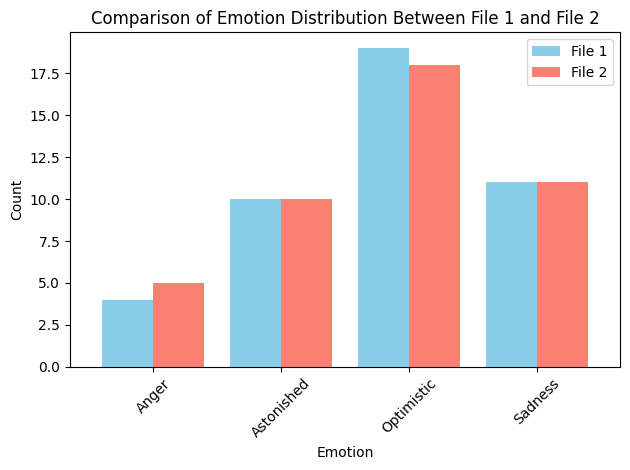

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both Excel files into DataFrames
df1 = pd.read_excel("output_with_sentiment_analysis1.xlsx")
df2 = pd.read_excel("output_with_sentiment_analysis2.xlsx")

# Compare sentiment labels between the two datasets
df_comparison = pd.DataFrame({
    'Text': df1['Shlok'],
    'Sentiment_Label_1': df1['label_column'],
    'Sentiment_Label_2': df2['label_column']
})

# Add a column to indicate if the sentiment labels match
df_comparison['Match'] = df_comparison['Sentiment_Label_1'] == df_comparison['Sentiment_Label_2']

# Analyze differences where sentiment labels don't match
df_diff = df_comparison[df_comparison['Match'] == False]
print(f"Number of differing predictions: {len(df_diff)}")
print(df_diff.head())

# Get emotion distribution from both datasets
emotion_dist_1 = df1['label_column'].value_counts().sort_index()
emotion_dist_2 = df2['label_column'].value_counts().sort_index()

# Combine both distributions into a single DataFrame for easy plotting
emotion_comparison_df = pd.DataFrame({
    'File 1': emotion_dist_1,
    'File 2': emotion_dist_2
}).fillna(0)  # Fill NaN with 0 for emotions not present in one of the files

# Plot the emotion distribution for both datasets
plt.figure(figsize=(10, 6))

# Plot bars for both files
emotion_comparison_df.plot(kind='bar', color=['skyblue', 'salmon'], width=0.8)

# Add titles and labels
plt.title('Comparison of Emotion Distribution Between File 1 and File 2')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['File 1', 'File 2'], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
import shutil 

# Compress the folder into a zip file
shutil.make_archive('/kaggle/working/G-Bert-Model', 'zip', '/kaggle/working/G-Bert-Model')

'/kaggle/working/G-Bert-Model.zip'

In [41]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# 1️⃣ Load CSV
csv_path = '/kaggle/input/modmod/modelcheck.csv'
df = pd.read_csv(csv_path)

# 2️⃣ Load model
model_path = '/kaggle/working/G-Bert-Model'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# 3️⃣ Emotion labels
emotion_labels = {
    0: "optimistic",
    1: "sadness",
    2: "anger",
    3: "astonished"
}

# 4️⃣ Prediction function
def predict_emotion(text):
    inputs = tokenizer(
        str(text),
        return_tensors="pt",
        truncation=True,
        padding=True
    )
    with torch.no_grad():
        logits = model(**inputs).logits
    pred_idx = torch.argmax(logits, dim=1).item()
    return emotion_labels[pred_idx]

# 5️⃣ Predict + match
df['Predicted'] = df['Text'].apply(predict_emotion)
df['Match'] = df.apply(
    lambda x: 1 if x['Predicted'].lower() == x['Emotion'].lower() else 0,
    axis=1
)

# 6️⃣ Match percentage
total = len(df)
matched = df['Match'].sum()
match_percentage = (matched / total) * 100

print(f"✅ Total samples   : {total}")
print(f"✅ Correct matches : {matched}")
print(f"🎯 Match Accuracy  : {match_percentage:.2f}%")



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ Total samples   : 249
✅ Correct matches : 61
🎯 Match Accuracy  : 24.50%


In [ ]:
# 7️⃣ Save CSV
output_path = '/kaggle/working/emotion_predictions_checked.csv'
df.to_csv(output_path, index=False)
print(f"📁 Saved at: {output_path}")
